In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from make_figure_functions import inter_number
from make_figure_functions import get_inters
from make_figure_functions import inter_mix_number
from matplotlib.patches import Wedge
import matplotlib as mpl
import math
import os

import anndata
import scanpy as sc

print('Load high-quality cells only')
fn_h5ad = '/home/yike/phd/dengue/data/mergedata_20210519_hq_cts.h5ad'
adata = sc.read_h5ad(fn_h5ad)
print('Normalize data to CPM')
sc.pp.normalize_total(adata, target_sum=1e6)

adata_children = adata[adata.obs['dataset'] == 'child']
adata_adults = adata[adata.obs['dataset'] == 'adult']
from adata_utilis import split_adata
adata_dic = split_adata(adata)

Load high-quality cells only
Normalize data to CPM


In [3]:
print('Load interaction') 
fn_int = '/home/yike/phd/dengue/data/interaction_source_file/interactions_DB.tsv'
interactions = pd.read_csv(fn_int, sep=',')[['gene_name_a', 'gene_name_b']]

print('Restrict to interaction genes')
genes = np.unique(interactions)
genes = [i for i in genes if i in adata.var_names]
# genes = genes - ['CCL3L3', 'CCL4L1', 'CCN6', 'KIR3DS1', 'YARS1']
adatag = adata[:, genes]

Load interaction
Restrict to interaction genes


In [4]:
res = pd.read_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/not_ID_ave/inter_genes_pvalue.tsv', index_col='cell_type')

up_genes_p = res[(- np.log10(res['pvalue']) >= 7) & (res['log2_fold_change'] >= 0.8)]
down_genes_p = res[(- np.log10(res['pvalue']) >= 7) & (res['log2_fold_change'] <= -0.8)]

up_p = {}
for ct in up_genes_p.index.unique().tolist():
    if isinstance(up_genes_p.loc[ct]['gene'], str):
        a = []
        a.append(up_genes_p.loc[ct]['gene'])
        up_p[ct] = a
    else:
        up_p[ct] = up_genes_p.loc[ct]['gene'].tolist()
        
down_p = {}
for ct in down_genes_p.index.unique().tolist():
    if isinstance(down_genes_p.loc[ct]['gene'], str):
        a = []
        a.append(down_genes_p.loc[ct]['gene'])
        down_p[ct] = a
    else:
        down_p[ct] = down_genes_p.loc[ct]['gene'].tolist()

up_up_p = get_inters(up_p, up_p)
up_up_p = up_up_p[ ~ up_up_p[['ga', 'gb']].duplicated()] ###to get the inters and don't care too much about cell types

#down & down
down_down_p = get_inters(down_p, down_p)
down_down_p = down_down_p[ ~ down_down_p[['ga', 'gb']].duplicated()] ###to get the inters and don't care too much about cell types

# up & down
up_down_p = get_inters(up_p, down_p)
up_down_p = up_down_p[ ~ up_down_p[['ga', 'gb']].duplicated()] ###to get the inters and don't care too much about cell types

Load interaction
Get interactions
Load interaction
Get interactions
Load interaction
Get interactions


In [5]:
up_up_p

,cta,ctb,ga,gb
1,Plasmablasts,Plasmablasts,CADM1,CADM1
3,Monocytes,Monocytes,FPR1,ANXA1
5,Monocytes,Monocytes,IL1B,IL1R2
7,Monocytes,Monocytes,IL18,IL18


In [6]:
down_down_p

,cta,ctb,ga,gb
1,Plasmablasts,Plasmablasts,GPRC5D,CCL4
3,Plasmablasts,Plasmablasts,LCK,CD8A
5,Plasmablasts,Plasmablasts,LCK,CD8B


In [7]:
up_down_p

,cta,ctb,ga,gb
0,Monocytes,Plasmablasts,CCL4,GPRC5D
1,NK_cells,Monocytes,CXCR3,CXCL10
3,NK_cells,T_cells,CLEC2D,KLRB1
4,NK_cells,Monocytes,ITGB1,COL6A3


In [129]:
################################## Define up, down, normal cell_types by log2_FC & com_frac & exp_frac
log2_fc_ave = pd.read_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/not_ID_ave/log2_fc_median.tsv', index_col=['cell_type', 'gene'])

up_cd = (log2_fc_ave['fold_2_change'] >= 1) & (log2_fc_ave['comp_frac'] >= 0.78125) & (log2_fc_ave['SD_exp_frac'] >= 0.02)
#up_cd = (log2_fc_ave['fold_2_change'] >= 0.8) & (np.log10(log2_fc_ave['pvalue']) <= -5) & (log2_fc_ave['SD_exp_frac'] >= 0.02)
up_df = log2_fc_ave[up_cd]
print('Number of up genes is %s' % up_df.shape[0])
up_cts = list(set([idx[0] for idx in up_df.index.tolist()]))
print('Cell types for up genes are %s' % up_cts)

down_cd = (log2_fc_ave['fold_2_change'] <= -1) & (log2_fc_ave['comp_frac'] <= 0.21875) & (log2_fc_ave['D_exp_frac'] >= 0.02)
#down_cd = (log2_fc_ave['fold_2_change'] <= -0.8) & (-np.log10(log2_fc_ave['pvalue']) >= 5) & (log2_fc_ave['D_exp_frac'] >= 0.02)
down_df = log2_fc_ave[down_cd]
print('Number of down genes is %s' % down_df.shape[0])
down_cts = list(set([idx[0] for idx in down_df.index.tolist()]))
print('Cell types for down genes are %s' % down_cts)

normal_df = log2_fc_ave[~ (up_cd | down_cd)]
print('Number of normal genes is %s' % normal_df.shape[0])
normal_cts = list(set([idx[0] for idx in normal_df.index.tolist()]))
print('Cell types for normal genes are %s' % normal_cts)

up_genes = {ct: up_df.loc[ct].index.tolist() for ct in up_cts}
down_genes = {ct: down_df.loc[ct].index.tolist() for ct in down_cts}
normal_genes = {ct: normal_df.loc[ct].index.tolist() for ct in normal_cts}

print('Get genes at each condition')

up_up_inters = get_inters(up_genes, up_genes)
#inter_number(up_up_inters, 15, 'up')
down_down_inters = get_inters(down_genes, down_genes)
#inter_number(down_down_inters, 20, 'down')
up_down_inters = get_inters(up_genes, down_genes)
#inter_mix_number(up_down_inters, 15)

######################################
def get_inter_info(up_im_all, up_up_inters):
    up_all_info = {idx: [cta, ctb, ga, gb]for idx, cta, ctb, ga, gb in zip(up_im_all.index.tolist(), up_im_all['cta'].tolist(), up_im_all['ctb'].tolist(), up_im_all['ga'].tolist(), up_im_all['gb'].tolist())}
    up_info = [[cta, ctb, ga, gb] for cta, ctb, ga, gb in zip(up_up_inters['cta'].tolist(), up_up_inters['ctb'].tolist(), up_up_inters['ga'].tolist(), up_up_inters['gb'].tolist())]

    up_up = pd.DataFrame([], columns = up_im_all.columns)
    for info in up_info:
        if info in up_all_info.values():
            idx = list(up_all_info.keys())[list(up_all_info.values()).index(info)]
            up_up.loc[idx] = up_im_all.loc[idx]

    return up_up
######################################
inters_im_all = pd.read_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/not_ID_ave/inters_im_all_002_median.tsv', index_col=0)
up_im_all = inters_im_all[inters_im_all['up/down'] == 'up']
down_im_all = inters_im_all[inters_im_all['up/down'] == 'down']

mix_im_all = pd.read_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/not_ID_ave/inters_mix_all_002_median.tsv', index_col=0)

up_up = get_inter_info(up_im_all, up_up_inters)
#up_up.to_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/not_ID_ave/up_up.tsv')

down_down = get_inter_info(down_im_all, down_down_inters)
#down_down.to_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/not_ID_ave/down_down.tsv')

up_down = get_inter_info(mix_im_all, up_down_inters)
#up_down.to_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/not_ID_ave/up_down.tsv')

Number of up genes is 51
Cell types for up genes are ['Plasmablasts', 'cDCs', 'NK_cells', 'T_cells', 'B_cells', 'Monocytes', 'pDCs']
Number of down genes is 72
Cell types for down genes are ['Plasmablasts', 'cDCs', 'NK_cells', 'T_cells', 'B_cells', 'Monocytes', 'pDCs']
Number of normal genes is 6485
Cell types for normal genes are ['Plasmablasts', 'cDCs', 'NK_cells', 'T_cells', 'B_cells', 'Monocytes', 'pDCs']
Get genes at each condition
Load interaction
Get interactions
Load interaction
Get interactions
Load interaction
Get interactions


In [143]:
up_up = pd.read_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/not_ID_ave/up_up.tsv', index_col=0)
down_down = pd.read_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/not_ID_ave/down_down.tsv', index_col=0)
up_down = pd.read_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/not_ID_ave/up_down.tsv', index_col=0)

In [132]:
a = up_up
#[(up_up['ga_SD_exp_frac'] >= 0.03) & (up_up['gb_SD_exp_frac'] >= 0.03)]
#a = up_up[(up_up['ga_comfrac'] > 0.7) & (up_up['gb_comfrac'] > 0.7)]
a

,ga,gb,cta,ctb,ga_log2FC,ga_comfrac,ga_D_exp_frac,ga_SD_exp_frac,gb_log2FC,gb_comfrac,gb_D_exp_frac,gb_SD_exp_frac,up/down
402,ADORA2A,ENTPD1,Plasmablasts,cDCs,1.165092,0.812500,0.013620,0.038002,1.078329,0.833333,0.070796,0.254167,up
211,ENTPD1,ADORA2A,NK_cells,Plasmablasts,1.906699,1.000000,0.003392,0.022377,1.165092,0.812500,0.013620,0.038002,up
1909,TNF,VSIR,cDCs,pDCs,1.945122,0.791667,0.053097,0.125000,1.549537,0.875000,0.141935,0.307359,up
936,TNFRSF1B,TNF,T_cells,cDCs,1.106875,0.781250,0.092539,0.150139,1.945122,0.791667,0.053097,0.125000,up
242,ITGAX,ICAM1,NK_cells,Plasmablasts,1.029201,0.906250,0.062555,0.131067,2.356626,0.937500,0.031076,0.063456,up
439,ICAM1,ITGB2,Plasmablasts,cDCs,2.356626,0.937500,0.031076,0.063456,1.051861,0.916667,0.716814,0.945833,up


In [133]:
b = down_down
#[(down_down['ga_D_exp_frac'] >= 0.03) & (down_down['gb_D_exp_frac'] >= 0.03)]
#b[(b['ga_comfrac'] <= 0.4) & (b['gb_comfrac'] <=0.4)]
b

,ga,gb,cta,ctb,ga_log2FC,ga_comfrac,ga_D_exp_frac,ga_SD_exp_frac,gb_log2FC,gb_comfrac,gb_D_exp_frac,gb_SD_exp_frac,up/down
2532,CD226,NECTIN2,Monocytes,cDCs,-1.568397,0.187500,0.023741,0.016160,-2.248722,0.208333,0.053097,0.029167,down
3498,LTB,LTBR,Plasmablasts,pDCs,-1.725172,0.156250,0.146557,0.029278,-2.467435,0.187500,0.070968,0.034632,down
3973,LTB,LTBR,cDCs,pDCs,-1.606390,0.083333,0.292035,0.258333,-2.467435,0.187500,0.070968,0.034632,down
3979,ADRB2,VEGFB,cDCs,pDCs,-4.842007,0.041667,0.115044,0.075000,-1.155984,0.156250,0.212903,0.199134,down
3983,CCL5,CCR5,cDCs,pDCs,-1.309427,0.208333,0.123894,0.145833,-3.773626,0.000000,0.025806,0.000000,down
3985,CCL4,CCR5,cDCs,pDCs,-4.237847,0.208333,0.035398,0.029167,-3.773626,0.000000,0.025806,0.000000,down
2557,CXCL10,DPP4,Monocytes,cDCs,-3.134766,0.218750,0.220035,0.044405,-5.417424,0.083333,0.053097,0.033333,down
2218,KLRF1,CLEC2B,Monocytes,Plasmablasts,-1.667614,0.187500,0.027794,0.010320,-1.040679,0.125000,0.138884,0.094288,down
4003,CCL3L1,CCR5,cDCs,pDCs,-6.451494,0.166667,0.035398,0.079167,-3.773626,0.000000,0.025806,0.000000,down
3795,CCL8,CCR5,Monocytes,pDCs,-4.437693,0.093750,0.024320,0.002988,-3.773626,0.000000,0.025806,0.000000,down


In [134]:
c = up_down
#[(up_down['ga_SD_exp_frac'] >= 0.05) & (up_down['gb_D_exp_frac'] >= 0.05)]
#c[(c['ga_comfrac'] <= 0.4) & (c['gb_comfrac'] <=0.4)]
c

,ga,gb,cta,ctb,ga_log2FC,ga_comfrac,ga_D_exp_frac,ga_SD_exp_frac,gb_log2FC,gb_comfrac,gb_D_exp_frac,gb_SD_exp_frac
8,CXCR3,CCL19,Plasmablasts,cDCs,1.631361,0.843750,0.286591,0.427701,-5.474215,0.000000,0.026549,0.000000
750,LTBR,LTB,cDCs,Plasmablasts,1.043720,0.833333,0.238938,0.400000,-1.725172,0.156250,0.146557,0.029278
927,CXCR3,CXCL10,Plasmablasts,Monocytes,1.631361,0.843750,0.286591,0.427701,-3.134766,0.218750,0.220035,0.044405
1072,TNF,FAS,cDCs,cDCs,1.945122,0.791667,0.053097,0.125000,-1.610747,0.166667,0.123894,0.100000
1566,CCR2,CCL2,Plasmablasts,Monocytes,1.432914,0.875000,0.139075,0.298996,-3.258525,0.156250,0.078749,0.016295
1897,RETN,GPR25,Monocytes,Plasmablasts,1.764595,1.000000,0.086856,0.326860,-1.072892,0.125000,0.054287,0.046965
1940,PDCD1,PDCD1LG2,T_cells,cDCs,1.241772,0.781250,0.039019,0.071321,-5.977256,0.041667,0.026549,0.004167
1977,DPP4,CXCL10,pDCs,Monocytes,2.703851,0.843750,0.025806,0.103896,-3.134766,0.218750,0.220035,0.044405
2082,SLC1A5,LGALS9,cDCs,Plasmablasts,6.209186,0.958333,0.088496,0.295833,-1.618701,0.093750,0.059083,0.052223
2080,SLC1A5,LGALS9,T_cells,Plasmablasts,1.399836,0.812500,0.025310,0.070786,-1.618701,0.093750,0.059083,0.052223


In [139]:
up_normal_inters = get_inters(up_genes, normal_genes)
up_normal = get_inter_info(up_im_all, up_normal_inters)
up_normal

Load interaction
Get interactions


,ga,gb,cta,ctb,ga_log2FC,ga_comfrac,ga_D_exp_frac,ga_SD_exp_frac,gb_log2FC,gb_comfrac,gb_D_exp_frac,gb_SD_exp_frac,up/down
399,ADORA2A,NAMPT,Plasmablasts,cDCs,1.165092,0.812500,0.013620,0.038002,0.771747,0.916667,0.265487,0.525000,up
660,ADORA2A,NAMPT,Plasmablasts,T_cells,1.165092,0.812500,0.013620,0.038002,0.395581,0.843750,0.054574,0.102056,up
843,TFRC,TNFSF13B,T_cells,T_cells,1.914870,0.875000,0.009755,0.032662,0.072558,0.531250,0.019246,0.025701,up
401,GAS6,AXL,Plasmablasts,cDCs,2.085609,0.968750,0.026664,0.183198,0.431843,0.583333,0.070796,0.100000,up
664,ADORA2A,ENTPD1,Plasmablasts,T_cells,1.165092,0.812500,0.013620,0.038002,1.722998,0.750000,0.013709,0.043050,up
1859,TNF,VSIR,cDCs,cDCs,1.945122,0.791667,0.053097,0.125000,0.336704,0.791667,0.575221,0.762500,up
1912,SORT1,COPA,cDCs,pDCs,5.802576,0.833333,0.008850,0.083333,0.559272,0.687500,0.148387,0.225108,up
368,LAMP1,FAM3C,Plasmablasts,Plasmablasts,1.342261,0.875000,0.059275,0.218929,0.417611,0.687500,0.236140,0.337596,up
667,LAMP1,FAM3C,Plasmablasts,T_cells,1.342261,0.875000,0.059275,0.218929,0.082778,0.562500,0.037701,0.056650,up
1325,LAMP1,FAM3C,Plasmablasts,pDCs,1.342261,0.875000,0.059275,0.218929,0.052706,0.531250,0.051613,0.116883,up


In [140]:
down_normal_inters = get_inters(down_genes, normal_genes)
down_normal = get_inter_info(down_im_all, down_normal_inters)
down_normal

Load interaction
Get interactions


,ga,gb,cta,ctb,ga_log2FC,ga_comfrac,ga_D_exp_frac,ga_SD_exp_frac,gb_log2FC,gb_comfrac,gb_D_exp_frac,gb_SD_exp_frac,up/down
2168,TNFSF10,TNFRSF10A,B_cells,Plasmablasts,-1.035919,0.125000,0.117257,0.092514,-0.442263,0.468750,0.029542,0.062978,down
2190,TNFSF10,TNFRSF10A,Monocytes,Plasmablasts,-1.488853,0.125000,0.750434,0.539245,-0.442263,0.468750,0.029542,0.062978,down
2196,KLRC1,HLA-E,Monocytes,Plasmablasts,-1.618203,0.187500,0.024320,0.010592,-0.430407,0.062500,0.871475,0.793977,down
2530,KLRC1,HLA-E,Monocytes,cDCs,-1.618203,0.187500,0.024320,0.010592,-0.527523,0.125000,0.840708,0.887500,down
2724,KLRC1,HLA-E,Monocytes,NK_cells,-1.618203,0.187500,0.024320,0.010592,-0.136807,0.281250,0.960558,0.961784,down
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2759,KLRD1,HLA-E,Monocytes,NK_cells,-1.186560,0.218750,0.075275,0.032048,-0.136807,0.281250,0.960558,0.961784,down
2072,KLRD1,HLA-E,Monocytes,T_cells,-1.186560,0.218750,0.075275,0.032048,-0.297473,0.125000,0.932507,0.938424,down
3802,KLRD1,HLA-E,Monocytes,pDCs,-1.186560,0.218750,0.075275,0.032048,-0.424451,0.250000,0.825806,0.831169,down
4091,KLRD1,HLA-E,pDCs,pDCs,-4.035663,0.187500,0.045161,0.030303,-0.424451,0.250000,0.825806,0.831169,down


Filter data for S_dnegue and dengue
Filter data for Monocytes 
Pick up 50 cells from each patient by random
Logarithm the picked data to log10


{'fig': <Figure size 1470x300 with 1 Axes>,
 'axs': <AxesSubplot:title={'center':'EREG in Monocytes'}, ylabel='Gene exp\n(log10[cpm+0.1])'>}

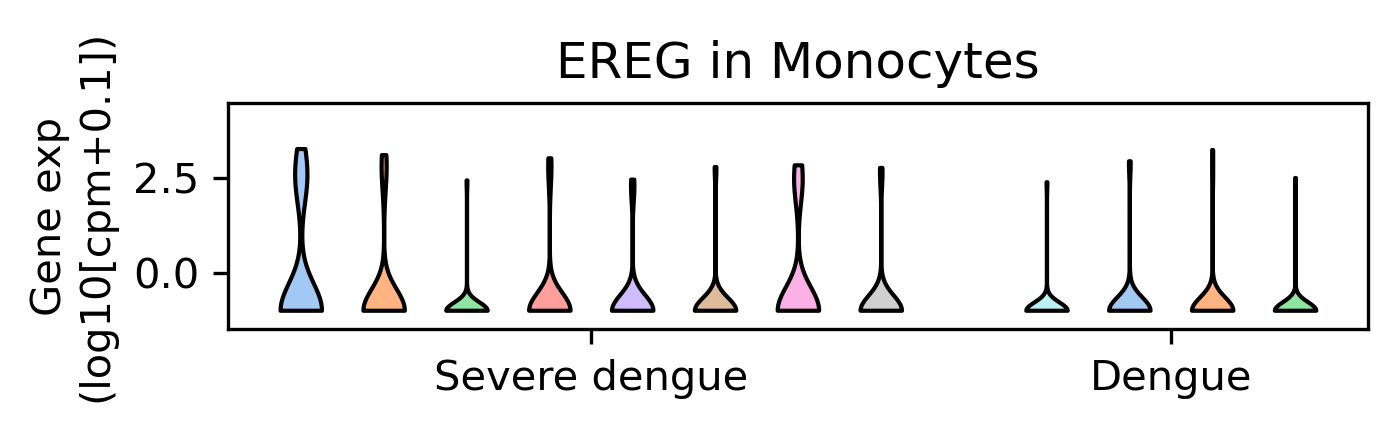

In [275]:
violin('EREG', 'Monocytes')

In [84]:
ZY_genes = pd.read_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/inters/all_deg_gene_Zhiyuan.tsv', sep='\t', index_col=['celltype', 'gene_name'])
cell_types = ['B_cells', 'Monocytes', 'NK_cells', 'Plasmablasts', 'T_cells', 'cDCs', 'pDCs']
ZY_up_genes = {ct:ZY_genes.loc[ct][ZY_genes.loc[ct]['log2_fold_change'] > 0].index.tolist() for ct in cell_types}
ZY_down_genes = {ct:ZY_genes.loc[ct][ZY_genes.loc[ct]['log2_fold_change'] < 0].index.tolist() for ct in cell_types}
######################################
ZY_up_up_inters = get_inters(ZY_up_genes, ZY_up_genes)
#inter_number(up_up_inters, 15, 'up')
ZY_down_down_inters = get_inters(ZY_down_genes, ZY_down_genes)
#inter_number(down_down_inters, 20, 'down')
ZY_up_down_inters = get_inters(ZY_up_genes, ZY_down_genes)
#inter_mix_number(up_down_inters, 15)

######################################
def get_inter_info(up_im_all, up_up_inters):
    up_all_info = {idx: [cta, ctb, ga, gb]for idx, cta, ctb, ga, gb in zip(up_im_all.index.tolist(), up_im_all['cta'].tolist(), up_im_all['ctb'].tolist(), up_im_all['ga'].tolist(), up_im_all['gb'].tolist())}
    up_info = [[cta, ctb, ga, gb] for cta, ctb, ga, gb in zip(up_up_inters['cta'].tolist(), up_up_inters['ctb'].tolist(), up_up_inters['ga'].tolist(), up_up_inters['gb'].tolist())]

    up_up = pd.DataFrame([], columns = up_im_all.columns)
    for info in up_info:
        if info in up_all_info.values():
            idx = list(up_all_info.keys())[list(up_all_info.values()).index(info)]
            up_up.loc[idx] = up_im_all.loc[idx]

    return up_up
######################################
inters_im_all = pd.read_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/not_ID_ave/inters_im_all_002.tsv', index_col=0)
up_im_all = inters_im_all[inters_im_all['up/down'] == 'up']
down_im_all = inters_im_all[inters_im_all['up/down'] == 'down']

mix_im_all = pd.read_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/not_ID_ave/inters_mix_all_002.tsv', index_col=0)

ZY_up_up = get_inter_info(up_im_all, ZY_up_up_inters)
#ZY_up_up.to_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/inters/final/ZY_up_up.tsv')

ZY_down_down = get_inter_info(down_im_all, ZY_down_down_inters)
#ZY_down_down.to_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/inters/final/ZY_down_down.tsv')

ZY_up_down = get_inter_info(mix_im_all, ZY_up_down_inters)
#ZY_up_down.to_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/inters/final/ZY_up_down.tsv')

Load interaction
Get interactions
Load interaction
Get interactions
Load interaction
Get interactions


In [87]:
ZY_up_down

,ga,gb,cta,ctb,ga_log2FC,ga_comfrac,ga_D_exp_frac,ga_SD_exp_frac,gb_log2FC,gb_comfrac,gb_D_exp_frac,gb_SD_exp_frac
1055,ALOX5,ALOX5AP,Monocytes,NK_cells,0.543037,0.75000,0.185871,0.333243,-0.816578,0.03125,0.648537,0.501598
1076,CXCR3,CXCL10,Plasmablasts,Monocytes,1.753582,0.84375,0.286591,0.427701,-2.538432,0.21875,0.220035,0.044405
3778,ITGB2,FCER2,Monocytes,B_cells,0.401199,0.81250,0.722640,0.854563,-0.645218,0.06250,0.429459,0.313603
3781,ITGB2,FCER2,T_cells,B_cells,0.213589,0.62500,0.470867,0.614050,-0.645218,0.06250,0.429459,0.313603
3828,ITGB2,ICAM2,Monocytes,NK_cells,0.401199,0.81250,0.722640,0.854563,-0.675492,0.03125,0.402713,0.295118
3844,ITGB2,ICAM2,T_cells,NK_cells,0.213589,0.62500,0.470867,0.614050,-0.675492,0.03125,0.402713,0.295118
3956,ITGAM,FCER2,Monocytes,B_cells,0.860385,0.84375,0.106543,0.264123,-0.645218,0.06250,0.429459,0.313603


In [169]:
def violin(gene, cell_type):
    print('Filter data for S_dnegue and dengue')
    adata_v = adata_children[adata_children.obs['Condition'].isin(['S_dengue', 'dengue'])]

    if cell_type == 'cDCs':
        adata_v = adata_v[~adata_v.obs['ID'].isin(['1_140_01', '5_193_01'])]

    print('Filter data for %s '%cell_type)
    adata_ct = adata_v[adata_v.obs['cell_type'] == cell_type]

    SD_IDs = list(adata_ct[adata_ct.obs['Condition'] == 'S_dengue'].obs['ID'].astype('category').cat.categories)
    D_IDs = list(adata_ct[adata_ct.obs['Condition'] == 'dengue'].obs['ID'].astype('category').cat.categories)

    print('Pick up 50 cells from each patient by random')
    df = pd.DataFrame([])
    for ID in SD_IDs + D_IDs:
        ID_info = adata_ct[adata_ct.obs['ID'] == ID][:, gene].X.toarray()[:, 0]
        if len(ID_info) < 50:
            df[ID] = np.random.choice(ID_info, size=50, replace=True)
        else:
            df[ID] = np.random.choice(ID_info, size=50, replace=False)
   
    print('Logarithm the picked data to log10')
    df = np.log10(df + 0.1)
    
    df[''] = [-100] * 50
    df = df[SD_IDs + [''] + D_IDs]
    
    fig, ax = plt.subplots(figsize=[1 + 0.3 * len(SD_IDs + [''] + D_IDs), 1], dpi=300)
    violin = ax.violinplot(df, showextrema=False)

    colors = sns.color_palette('pastel', len(SD_IDs + [''] + D_IDs))
    for i, patch in enumerate(violin['bodies']):
        patch.set_facecolor(colors[i])
        patch.set_edgecolor('black')
        patch.set_alpha(1)
    ax.set_xticks([0.5 + len(SD_IDs)/2, len(SD_IDs) + 1.5 + len(D_IDs)/2])
    ax.set_xticklabels(['Severe dengue', 'Dengue'])
    ax.set_ylabel('Gene exp\n(log10[cpm+0.1])')
    ax.set_ylim([-1.5, 4.5])
    ax.set_title(gene + ' in ' + cell_type.replace('_', ' '))
    fig.savefig('/home/yike/phd/dengue/data/paper_figure/figure_v7/genes/final/%s_in_%s.png'%(gene, cell_type), bbox_inches = 'tight')
    return {'fig': fig, 'axs': ax}

In [3]:
SD_inters = pd.read_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/inters/final/specific_SD_inters005.tsv', index_col=['cta', 'ctb'])
a = SD_inters[SD_inters.duplicated()]
inter_ls = [[ga, gb] for ga, gb in zip(a['ga'].tolist(), a['gb'].tolist())]

inter_n = {(inter[0], inter[1]): 0 for inter in inter_ls}

for inter in inter_n:
    for _,row in SD_inters.iterrows():
        ga = row['ga']
        gb = row['gb']
        
        if (ga == inter[0]) & (gb == inter[1]):
            inter_n[inter] +=1
SD_inter_n = sorted(inter_n.items(), key=lambda x: x[1], reverse=True)
###########################################################################

D_inters = pd.read_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/inters/final/specific_D_inters005.tsv', index_col=['cta', 'ctb'])
a = D_inters[D_inters.duplicated()]
inter_ls = [[ga, gb] for ga, gb in zip(a['ga'].tolist(), a['gb'].tolist())]

inter_n = {(inter[0], inter[1]): 0 for inter in inter_ls}

for inter in inter_n:
    for _,row in SD_inters.iterrows():
        ga = row['ga']
        gb = row['gb']
        
        if (ga == inter[0]) & (gb == inter[1]):
            inter_n[inter] +=1
D_inter_n = sorted(inter_n.items(), key=lambda x: x[1], reverse=True)

In [255]:
log2_fc_ncM = pd.read_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/not_ID_ave/log2_fc_ncM.tsv', index_col=0)

In [268]:
log2_fc_ncM[(log2_fc_ncM['fold_2_change'] >= 1)]
# & (np.log10(log2_fc_ncM['pvalue']) <= -3)

,fold_2_change,comp_frac,cell_type,pvalue
CXCL2,2.197109,0.59375,non_classical_monocytes,0.574140
ADM,1.672181,0.84375,non_classical_monocytes,0.002891
VIPR1,1.636601,0.59375,non_classical_monocytes,1.000000
DSC2,1.476532,0.59375,non_classical_monocytes,0.741063
CXCL8,1.065988,0.59375,non_classical_monocytes,0.000304


In [267]:
log2_fc_ncM[(log2_fc_ncM['fold_2_change'] <= -1) & (np.log10(log2_fc_ncM['pvalue']) <= -3)]

,fold_2_change,comp_frac,cell_type,pvalue
MS4A4A,-1.174158,0.18750,non_classical_monocytes,6.008626e-16
COL6A3,-2.436431,0.28125,non_classical_monocytes,1.021643e-06
CXCL10,-3.900501,0.12500,non_classical_monocytes,1.596571e-21


In [269]:
log2_fc_ave = pd.read_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/not_ID_ave/log2_fc_median.tsv', index_col=['cell_type', 'gene'])

In [272]:
log2_fc_ave.loc['Monocytes'][(log2_fc_ave.loc['Monocytes']['fold_2_change'] >= 1) & (np.log10(log2_fc_ave.loc['Monocytes']['pvalue']) <= -3)]

,fold_2_change,comp_frac,statistic,pvalue,SD_exp_frac,D_exp_frac,SD_ave_exp,D_ave_exp
gene,,,,,,,,
FLT3,2.338787,0.90625,0.061357,5.051128e-05,0.068305,0.006948,23.965120,1.855580
RETN,1.764595,1.00000,0.240005,2.096331e-71,0.326860,0.086856,235.352540,40.257620
EREG,1.539348,0.81250,0.151049,2.479275e-28,0.178843,0.027794,108.033500,14.378305
ASGR2,1.052210,0.87500,0.119085,9.592348e-18,0.224470,0.105385,85.300860,43.055680
APP,1.392254,1.00000,0.077577,9.017703e-08,0.138376,0.060799,43.792150,22.000940
CXCL8,1.115851,0.78125,0.330189,2.139930e-136,0.546171,0.215981,603.280330,145.713970
ADM,1.029872,0.71875,0.063494,2.387540e-05,0.101711,0.038217,35.744637,16.193913
CCL4L2,1.188509,0.68750,0.105135,6.206147e-14,0.137561,0.032426,149.956270,19.636675


In [177]:
inters_endo = pd.read_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/not_ID_ave/inters_endo.tsv', index_col=[0, 'cta'])
endo = inters_endo[(inters_endo['ga_log2FC'] >= 1) | (inters_endo['ga_log2FC'] <= -1) ]
endo_up = endo.loc['up']
endo_down = endo.loc['down']

In [208]:
################################## Define up, down, normal cell_types by log2_FC & com_frac & exp_frac
log2_fc_ave = pd.read_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/not_ID_ave/log2_fc_median.tsv', index_col=['cell_type', 'gene'])

up_cd = (log2_fc_ave['fold_2_change'] >= 1) & (log2_fc_ave['comp_frac'] >= 0.78125) & (log2_fc_ave['SD_exp_frac'] >= 0.02)
#up_cd = (log2_fc_ave['fold_2_change'] >= 0.8) & (np.log10(log2_fc_ave['pvalue']) <= -5) & (log2_fc_ave['SD_exp_frac'] >= 0.02)
up_df = log2_fc_ave[up_cd]
print('Number of up genes is %s' % up_df.shape[0])
up_cts = list(set([idx[0] for idx in up_df.index.tolist()]))
print('Cell types for up genes are %s' % up_cts)

down_cd = (log2_fc_ave['fold_2_change'] <= -1) & (log2_fc_ave['comp_frac'] <= 0.21875) & (log2_fc_ave['D_exp_frac'] >= 0.02)
#down_cd = (log2_fc_ave['fold_2_change'] <= -0.8) & (-np.log10(log2_fc_ave['pvalue']) >= 5) & (log2_fc_ave['D_exp_frac'] >= 0.02)
down_df = log2_fc_ave[down_cd]
print('Number of down genes is %s' % down_df.shape[0])
down_cts = list(set([idx[0] for idx in down_df.index.tolist()]))
print('Cell types for down genes are %s' % down_cts)

normal_df = log2_fc_ave[~ (up_cd | down_cd)]
print('Number of normal genes is %s' % normal_df.shape[0])
normal_cts = list(set([idx[0] for idx in normal_df.index.tolist()]))
print('Cell types for normal genes are %s' % normal_cts)

up_genes = {ct: up_df.loc[ct].index.tolist() for ct in up_cts}
down_genes = {ct: down_df.loc[ct].index.tolist() for ct in down_cts}
normal_genes = {ct: normal_df.loc[ct].index.tolist() for ct in normal_cts}

print('Get genes at each condition')

Number of up genes is 51
Cell types for up genes are ['Plasmablasts', 'cDCs', 'NK_cells', 'T_cells', 'B_cells', 'Monocytes', 'pDCs']
Number of down genes is 72
Cell types for down genes are ['Plasmablasts', 'cDCs', 'NK_cells', 'T_cells', 'B_cells', 'Monocytes', 'pDCs']
Number of normal genes is 6485
Cell types for normal genes are ['Plasmablasts', 'cDCs', 'NK_cells', 'T_cells', 'B_cells', 'Monocytes', 'pDCs']
Get genes at each condition


In [209]:
exp_endo = pd.read_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/not_ID_ave/endo_ave_fra.tsv', index_col=0)
endo_genes = exp_endo[exp_endo['exp_fra'] >= 0.05].index.tolist()
endo_genes = {'endo_cells': endo_genes}

up_inters = get_inters(up_genes, endo_genes)
#inter_number(up_up_inters, 15, 'up')
down_inters = get_inters(down_genes, endo_genes)
#inter_number(down_down_inters, 20, 'down')

Load interaction
Get interactions
Load interaction
Get interactions


In [237]:
def get_endo_inter(up_im_all, up_up_inters):
    up_all_info = {idx: [cta, ga, gb] for idx, cta, ga, gb in zip(up_im_all.index.tolist(), up_im_all['cta'].tolist(), up_im_all['ga'].tolist(), up_im_all['gb'].tolist())}
    up_info = [[cta, ga, gb] for cta, ga, gb in zip(up_up_inters['cta'].tolist(), up_up_inters['ga'].tolist(), up_up_inters['gb'].tolist())]

    up_up = pd.DataFrame([], columns = up_im_all.columns)
    for info in up_info:
        if info in up_all_info.values():
            idx = list(up_all_info.keys())[list(up_all_info.values()).index(info)]
            up_up.loc[idx] = up_im_all.loc[idx]

    return up_up

inters_endo = pd.read_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/not_ID_ave/inters_endo_strict.tsv', index_col=0)
endo_up = inters_endo.loc['up']
endo_up.index = pd.Index(range(endo_up.shape[0]))
endo_down = inters_endo.loc['down']
endo_down.index = pd.Index(range(endo_down.shape[0]))

up_endo = get_endo_inter(endo_up, up_inters)
#up_up.to_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/not_ID_ave/up_up.tsv')

down_endo = get_endo_inter(endo_down, down_inters)
#down_down.to_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/not_ID_ave/down_down.tsv')

In [246]:
up_endo

,ga,gb,ga_log2FC,ga_com_frac,ga_fra_SD,ga_fra_D,gb_fra_endo
cta,,,,,,,
cDCs,EREG,EGFR,5.521429,1.000000,0.116667,0.026549,0.119937
Monocytes,EREG,EGFR,1.539348,0.812500,0.178843,0.027794,0.119937
T_cells,PDCD1,CD274,1.241772,0.781250,0.071321,0.039019,0.126785
cDCs,NOTCH2,JAG2,1.071682,0.916667,0.204167,0.061947,0.226343
cDCs,NOTCH2,DLL4,1.071682,0.916667,0.204167,0.061947,0.193769
cDCs,TNF,NOTCH1,1.945122,0.791667,0.125000,0.053097,0.373591
cDCs,TNF,VSIR,1.945122,0.791667,0.125000,0.053097,0.299424
Plasmablasts,GAS6,MERTK,2.085609,0.968750,0.183198,0.026664,0.064562
cDCs,NOTCH2,DLL1,1.071682,0.916667,0.204167,0.061947,0.174225


In [247]:
#down_endo = down_endo.set_index('cta')
down_endo

,ga,gb,ga_log2FC,ga_com_frac,ga_fra_SD,ga_fra_D,gb_fra_endo
cta,,,,,,,
B_cells,TNFSF10,TNFRSF10A,-1.035919,0.125000,0.092514,0.117257,0.271611
Monocytes,TNFSF10,TNFRSF10A,-1.488853,0.125000,0.539245,0.750434,0.271611
pDCs,TNFSF10,TNFRSF10A,-2.631927,0.125000,0.125541,0.245161,0.271611
cDCs,NECTIN2,NECTIN3,-2.248722,0.208333,0.029167,0.053097,0.077925
Plasmablasts,CX3CR1,CX3CL1,-1.528090,0.156250,0.021750,0.064262,0.352209
Monocytes,CX3CR1,CX3CL1,-1.450321,0.093750,0.101032,0.231036,0.352209
pDCs,VEGFB,NRP1,-1.155984,0.156250,0.199134,0.212903,0.640023
cDCs,CCL5,ACKR1,-1.309427,0.208333,0.145833,0.123894,0.548066
Plasmablasts,LTB,LTBR,-1.725172,0.156250,0.029278,0.146557,0.329658
